# Deep Neural Network

We attempt to implement a neural network for giving predictions. Appropriate articles explaining:
* [Regression with Neural Networks in PyTorch](https://medium.com/@benjamin.phillips22/simple-regression-with-neural-networks-in-pytorch-313f06910379) (Medium)
* [How to create a neural network for regression with PyTorch](https://www.machinecurve.com/index.php/2021/07/20/how-to-create-a-neural-network-for-regression-with-pytorch/) (Machinecurve.com)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.metrics import mean_absolute_percentage_error as mape # usage : print(mape(pred, observed))

import datetime

import torch

path = 'C:/Users/sebir/Desktop/M2 Toulouse/Défi IA/'

# Import data

In [2]:
# Training set, X
X = pd.read_csv(path + 'X_station_train.csv',
                parse_dates=['date'],
                infer_datetime_format=True)
X.columns = ['number_sta', 'date', 'wind_speed', 'temperature', 'dew_point_temperature', 'humidity', 'wind_direction', 'precipitation', 'Id']

# X_agg_filledNA = pd.read_csv(path + 'our_X_agg_filled_nearestNeighbours.csv',
#                              parse_dates=['day'],
#                              infer_datetime_format=True)

# Training set, Y
Y = pd.read_csv(path + 'Y_train.csv',
                parse_dates=['date'],
                infer_datetime_format=True)

# Y_filledwithNA = pd.read_csv(path + 'Y_train.csv',
#                 parse_dates=['date'],
#                 infer_datetime_format=True)

# Preprocess data

## `X` hourly to `X_agg`

We have to group the data by data in order to have something comparable with `Y`

In [3]:
X['day'] = X['date'].apply(lambda x: x.date())

In [4]:
X_agg = X.copy()
X_agg = X_agg.groupby(by = ['day', 'number_sta'], as_index = False).agg({
    "number_sta"            : "first",
    "wind_speed"            : "median",
    "temperature"           : "median",
    "dew_point_temperature" : "median",
    "humidity"              : "median",
    "wind_direction"        : "median",
    "precipitation"         : "sum"
})

We firstly drop all the NAs.

In [5]:
X_agg.dropna(inplace = True)
Y = Y.loc[X_agg.index]

Y.dropna(inplace = True)
X_agg = X_agg.loc[Y.index]

Adding the month before deleting the date, since we have this information in `X_test`:

In [6]:
X_agg['month'] = X_agg['day'].apply(lambda x: x.month)

We then delete the Id in `Y` which won't be helpful

In [7]:
X_agg.drop(['day'], axis = 1, inplace = True)
Y.drop(['date', 'Id'], axis = 1, inplace = True)

## `X_agg_filledNA`
We took `X_agg` and we filled the gaps with data from nearests neighbours. Preprocessing data for coherence with `Y`:

Adding the month before deleting the date, since we have this information in `X_test`:

In [ ]:
X_agg_filledNA['month'] = X_agg_filledNA['day'].apply(lambda x: x.month)
X_agg_filledNA.drop('day', axis = 1, inplace = True)

In [ ]:
Y_filledwithNA.dropna(inplace = True)
X_agg_filledNA = X_agg_filledNA.loc[Y_filledwithNA.index]

<center><h1>Neural network

## Imports

In [8]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

## Represent data set

In [9]:
class MeteoDataset(torch.utils.data.Dataset):
    '''
    Prepare the dataset for regression
    '''

    def __init__(self, X, y, scale_data=True):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            # Apply scaling if necessary
            if scale_data:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

## Creating the MLP

In [63]:
class MLP(nn.Module):
    '''
    Multilayer Perceptron for regression.
    '''
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(8, 100), # size of the input is here
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )


    def forward(self, x):
        '''
        Forward pass
        '''
        return self.layers(x)

## Load data set

In [57]:
torch.manual_seed(42);

In [58]:
from sklearn.model_selection import train_test_split

X = X_agg.to_numpy()
y = Y['Ground_truth'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [59]:
dataset = MeteoDataset(X_train, y_train)
trainloader = torch.utils.data.DataLoader(dataset,
                                          batch_size = 100,
                                          shuffle = True,
                                          # num_workers=1
                                         )

## Set up

In [75]:
# Reinitialize completely
mlp = 0
loss_function = 0
optimizer = 0


# Initialize the MLP
mlp = MLP()

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr = 0.0001)

## Run

Starting epoch 1/50
Starting epoch 2/50
Starting epoch 3/50
Starting epoch 4/50
Starting epoch 5/50
Starting epoch 6/50
Starting epoch 7/50
Starting epoch 8/50
Starting epoch 9/50
Starting epoch 10/50
Starting epoch 11/50
Starting epoch 12/50
Starting epoch 13/50
Starting epoch 14/50
Starting epoch 15/50
Starting epoch 16/50
Starting epoch 17/50
Starting epoch 18/50
Starting epoch 19/50
Starting epoch 20/50
Starting epoch 21/50
Starting epoch 22/50
Starting epoch 23/50
Starting epoch 24/50
Starting epoch 25/50
Starting epoch 26/50
Starting epoch 27/50
Starting epoch 28/50
Starting epoch 29/50
Starting epoch 30/50
Starting epoch 31/50
Starting epoch 32/50
Starting epoch 33/50
Starting epoch 34/50
Starting epoch 35/50
Starting epoch 36/50
Starting epoch 37/50
Starting epoch 38/50
Starting epoch 39/50
Starting epoch 40/50
Starting epoch 41/50
Starting epoch 42/50
Starting epoch 43/50
Starting epoch 44/50
Starting epoch 45/50
Starting epoch 46/50
Starting epoch 47/50
Starting epoch 48/50
S

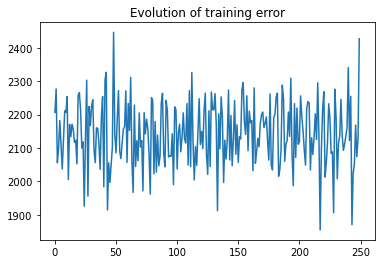

In [76]:
# Run the training loop
nbEpoch = 50
losses = []
for epoch in range(nbEpoch):
    print(f'Starting epoch {epoch+1}/{nbEpoch}')

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, start = 1):

        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 0:
            # print('Loss after mini-batch %5d: %.3f' % (i + 1, current_loss))
            losses.append(current_loss)
            current_loss = 0.0

# Process is complete.
print('Training process has finished.')
plt.plot(losses);
plt.title('Evolution of training error');

## Predictions

In [28]:
testset = MeteoDataset(X_test, y_test)
testloader = torch.utils.data.DataLoader(testset)

In [77]:
outputs = []
for i, data in enumerate(testloader, 0):

        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        # Perform forward pass
        outputs.append(mlp(inputs).detach().item())
        
mape(outputs, y_test)

9.520645842906845